# DSCI552: HW6
### Alain Tamazian
### ID#: 2073746513

In [1]:
# Cell for all imports necessary for HW6

import statistics
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from tqdm import tqdm
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.utils import check_random_state
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier

from scipy.special import softmax
from scipy.spatial.distance import cdist



In [2]:
# uncomment one or two of the lines below to adjust max visible columns/rows in the data frames

pd.set_option("display.max_rows", 10)
# pd.set_option("display.max_columns", 10)
# pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)

In [3]:
# As discussed with TA, the Convergence Failure warning can be rather arbitary; Having a few warning is not a problem
# For example, convergence warning is based on how our machine processes float point operations and rounding; a possible scenario is that our values are actually converging, it's just a recurring number
# Every time the processor goes through the cycle, the value changes by a negligible bit; 
# I also set a high max_iter to make sure the results are informative -- despite the notebook running longer as a results
simplefilter("ignore", category=ConvergenceWarning)
# or
warnings.filterwarnings("ignore")
# We go through a lot of loops -- especially when considering CV; we don't wan't to interupt our desired outputs with irrelevant (potential) warnings



-----------------

# 1. Supervised, Semi-Supervised, and Unsupervised Learning

## 1.a
Download the Breast Cancer Wisconsin (Diagnostic) Data Set from:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. 
Download the data in https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.

In [4]:
wdbc_data = "../data/wdbc.data.csv"

# wdbc_attr = "../data/wdbc.name.txt"
# I basically hard coded the attribute names using the information from "wdbc.name.txt"
# Couldn't find a pattern (that wasn't too convoluted) in the text to dynamically code the names
attr_nameL = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity" , "concave points", "symmetry", "fractal dimension"] 
attr_metricL = ["mean", "SE", "'worst'"]

# The attributes are the mean, standard error, and "worst"/largest (mean) of real-valued features computed for each cell nucleus 
attrL = ["ID Number", "Diagnosis"]
for metric in attr_metricL:
    for name in attr_nameL:
        attrL.append(name+" "+metric)

wdbc_total_orig = pd.read_csv(wdbc_data, header=None, names=attrL)
# display(wdbc_total_orig)


In [5]:
# We need to encode our Diagnosis label classes with numbers
# In the cell below, is a block of code that does this
# However, I found a easy, built-in pandas method for it

wdbc_total_orig.replace({"M" : 1, "B" : 0}, inplace=True)
display(wdbc_total_orig)

# wdbc_total_orig["Diagnosis"].value_counts()

,ID Number,Diagnosis,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,symmetry mean,fractal dimension mean,radius SE,texture SE,perimeter SE,area SE,smoothness SE,compactness SE,concavity SE,concave points SE,symmetry SE,fractal dimension SE,radius 'worst',texture 'worst',perimeter 'worst',area 'worst',smoothness 'worst',compactness 'worst',concavity 'worst',concave points 'worst',symmetry 'worst',fractal dimension 'worst'
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [6]:
# classes = []

# for clss in wdbc_total_orig["Diagnosis"]:
#     clss = str(clss)
#     # I added the "or" operator in case you do run the program with the .dat file instead
#     if clss == "M":
#         classes.append(1)
#     else:
#         classes.append(0)

# # resets and paris the existing "class" key with the new binary label values we converted to
# wdbc_total_orig["Diagnosis"] = classes
# # print(med_dict)

# # This is our new dataframe with the classes encoded with 1 and 0
# wdbc_total_orig["Diagnosis"] = classes
# display(wdbc_total_orig)


-----------------
## 1.b.i -  Supervised Learning
(b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly se- lected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

i. Supervised Learning: Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

# This function will be used for other subquestions down the line as well

def classification_summary(best_C, trainX, trainY, testX, testY, set_type, plot=False):
    
    svc_model = LinearSVC(penalty="l1", C=best_C, dual=False, max_iter=500000)
    svc_model.fit(trainX, trainY)

    # our classifier's label predictions
    prediction = svc_model.predict(testX)
    # the prediction probabilities are used for the ROC/AUC
    conf_scores = svc_model.decision_function(testX)
    # roc_curve()'s second parameter (y_score) can either be:
    # probability estimates of the positive class, confidence values, or non-thresholded measure of decisions 
    # generally, I use predict_proba but LinearSVC doesn't have that method; decision_function satisfies the req for the y_score param

    # could use sklearn.calibration.CalibratedClassifierCV ???
    
    matrix = confusion_matrix(testY, prediction)
    # print(matrix)
    
    matrix_flat = matrix.flatten()
    tn = matrix_flat[0]
    fp = matrix_flat[1]
    fn = matrix_flat[2]
    tp = matrix_flat[3]
    
    if plot:
        print("\nSample Simulation of L1-Penalized SVC Results (on", set_type + ")")
        
        # https://seaborn.pydata.org/generated/seaborn.heatmap.html
        sns.heatmap(matrix, annot=True)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

    
    # performance metrics
    accuracy = (tp+tn)/(tp+fn+tn+fp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    # could use classification_report() function ???


    # AUC/ROC

    # pos_label is the label of the positive class
    fpr, tpr, thresh = roc_curve(testY, conf_scores, pos_label=1)

    # area under the ROC curve
    auc_val = auc(fpr, tpr)
    # print(auc_val)
    
    if plot:
        # setting plot size
        fig, ax = plt.subplots(figsize=(14, 9))
        # plots the predicitve power (i.e. prob curve) of our classifier
        ax.plot(fpr, tpr, label="ROC", linewidth=3)
        # plots the predictive power we would expect with random guessing
        ax.plot([0, 1], [0, 1], "--", label="Random Chance")
        ax.legend(loc="lower right", fontsize="xx-large")
        kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
        # The blue shaded region represnts the AOC -- ie it covers 100% of the area under ROC; 
        ax.fill_between(fpr, tpr, **kwargs)

        plt.grid(True)
        plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
        plt.tick_params(labelsize=13)
        plt.xlabel("False Positive Rate", fontsize=15)
        plt.ylabel("True Positive Rate", fontsize=15)
        plt.title("ROC (and its AUC) of SVC", fontsize=20)

        plt.show()

    return accuracy, precision, recall, f1, auc_val


In [8]:
# At the end of (b), we need to ompare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm
overall_summaryD = {}

# Monte Carlo requires an element of randomness; since when dual=False SVC isn't random, we need to randomly split the train/test set for each simulation
def Sup_MonteCarlo(alg):
    
    # I am going to output all of the relevant findings from the Monte Carlo simulations loops as a dataframe
    summary_df = pd.DataFrame(columns = ["Optimal C", "Train: Accuracy", "Train: Precision", "Train: Recall", "Train: F1-Score", "Train: AUC", "Test: Accuracy", "Test: Precision", "Test: Recall", "Test: F1-Score", "Test: AUC"])
    
    simulations = 30
    
    for M in range(simulations): 

        # I randomized the instances here; this is the varying element of randomness for the Monte Carlo
        wdbc_total = wdbc_total_orig.sample(frac=1, random_state=M).reset_index(drop=True)


        # These give the indices of our wdbc_total dataframe that satisfy the condition -- e.g. Diagnosis = 0 
        indices_0 = np.where(wdbc_total["Diagnosis"] == 0)[0]
        indices_1 = np.where(wdbc_total["Diagnosis"] == 1)[0]

        # we have seperate dataframes for wdbc when Diagnosis is 0 or 1
        wdbc_0 = pd.DataFrame(wdbc_total.iloc[indices_0], columns=wdbc_total.columns)
        wdbc_1 = pd.DataFrame(wdbc_total.iloc[indices_1], columns=wdbc_total.columns)

        # now we can take 20% of each to create the test set; and the training set with the remainder
        wdbc_test0 = wdbc_0.iloc[:round(wdbc_0.shape[0]*0.2)]
        wdbc_test1 = wdbc_1.iloc[:round(wdbc_1.shape[0]*0.2)]
        wdbc_train0 = wdbc_0.iloc[round(wdbc_0.shape[0]*0.2):]
        wdbc_train1 = wdbc_1.iloc[round(wdbc_1.shape[0]*0.2):]

        # We use the axis=0 parameter to indicate that it is the rows of the DFs that are being joined together.
        wdbc_test = pd.concat([wdbc_test0, wdbc_test1], ignore_index=True, axis=0)
        wdbc_train = pd.concat([wdbc_train0, wdbc_train1], ignore_index=True, axis=0)

        
        # The ID Number parameter isn't relevant for our tasks; so we ignore it here
        testX = wdbc_test.iloc[:, 2:]
        testY = wdbc_test.iloc[:, 1]
        trainX = wdbc_train.iloc[:, 2:]
        trainY = wdbc_train.iloc[:, 1]

        # we are told to normalize the data
        # First we need to train the normalizer on the train set and use that to transform both the training set and test so -- to avoid data leakage

        normalizer = MinMaxScaler()
        trainX_norm = pd.DataFrame(normalizer.fit_transform(trainX), columns=trainX.columns)
        testX_norm = pd.DataFrame(normalizer.transform(testX), columns=testX.columns)
        # Technically, the proper way to normalize with CV is by applying it within the CV folds (like with a pipeline) -- so there's no data leak
        # However, in Piazza @647 the professor said, "Standardization is not a form of learning so it’s not a big deal to standardize outside the CV loop."
        # The same is true for normalization; so, I did it this way for the sake of simplicity

    
        # hyper-parameter tuning (on the train set) for the penalty/regularization parameter C
        # As suggested in footnote 4, manually tested and found very small and very large parameters for a range -- with a lower limit of ~70%
        C_set = [10**x for x in range(-3, 7, 1)]

        cv_scoreL = []
        for C in C_set:
            # "When dual=False the underlying implementation of LinearSVC is not random and random_state has no effect on the results."
            svc_model = LinearSVC(penalty="l1", C=C, dual=False, max_iter=500000)

            # using a 5-fold cross validation
            cv_score = cross_val_score(svc_model, trainX_norm, trainY, cv=5, scoring="accuracy").mean()
            # Since the estimator is a classifier and y is multiclass, StratifiedKFold is used for the cv parameter.
#             print("When C =", str(C) + ":\n\tCV (accuracy) Score =", cv_score)
            cv_scoreL.append((C, cv_score))

        # We use the parameter combo with the highest CV accuracy to train our SVC model
        cv_scoreL.sort(reverse=True, key=lambda x:x[1])
        best_C = cv_scoreL[0][0]
#         print("Best C:", best_C)    
    
       
        # Plot the ROC and report the confusion matrix for training and testing in one of the runs.
        
        # 1 is arbitary; could choose any of the 0-29 simulations
        if M == 1:
            accuracy_train, precision_train, recall_train, f1_train, auc_train = classification_summary(best_C, trainX_norm, trainY, trainX_norm, trainY, "Train Set", True)
            accuracy_test, precision_test, recall_test, f1_test, auc_test = classification_summary(best_C, trainX_norm, trainY, testX_norm, testY, "Test Set", True)
        else:
            accuracy_train, precision_train, recall_train, f1_train, auc_train = classification_summary(best_C, trainX_norm, trainY, trainX_norm, trainY, "Train Set")
            accuracy_test, precision_test, recall_test, f1_test, auc_test = classification_summary(best_C, trainX_norm, trainY, testX_norm, testY, "Test Set")

        row = [best_C, accuracy_train, precision_train, recall_train, f1_train, auc_train, accuracy_test, precision_test, recall_test, f1_test, auc_test]
        
        num = M+1
        # adding a new row to an existing dataframe (with the ".loc" method)
        summary_df.loc["Sim%d" %num] = row
    
    
    print("\nSVC Performance Results from 30 Monte Carlo Simulations")
    pd.set_option('display.max_rows', None)
    display(summary_df)
    pd.set_option("display.max_rows", 10)
    
    print("\nClassifier's Monte Carlo performance values (i.e. the average of the 30 simulations)"+\
          "\n____________________________________________________________________________________")

    
    # this is a dictionary that contains the Monte Carlo results
    monte_carloD = {}
    # in this loop, we take the average of all of our performance metrics and assign them to our dictionary
    for col in summary_df.columns[1:]:
        name = col+"_avg"
        avg = round( summary_df[col].mean(), 4)
        monte_carloD[name] = avg
        print(name + ":", avg)
    
    overall_summaryD[alg] = monte_carloD
    

Classification with Supervised Learning


Sample Simulation of L1-Penalized SVC Results (on Train Set)


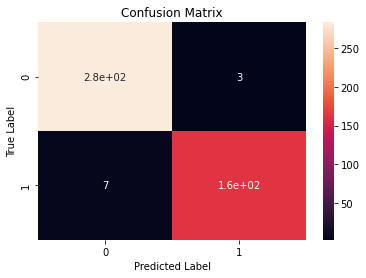

TN = 283 
FP = 3 
FN = 7 
TP = 163


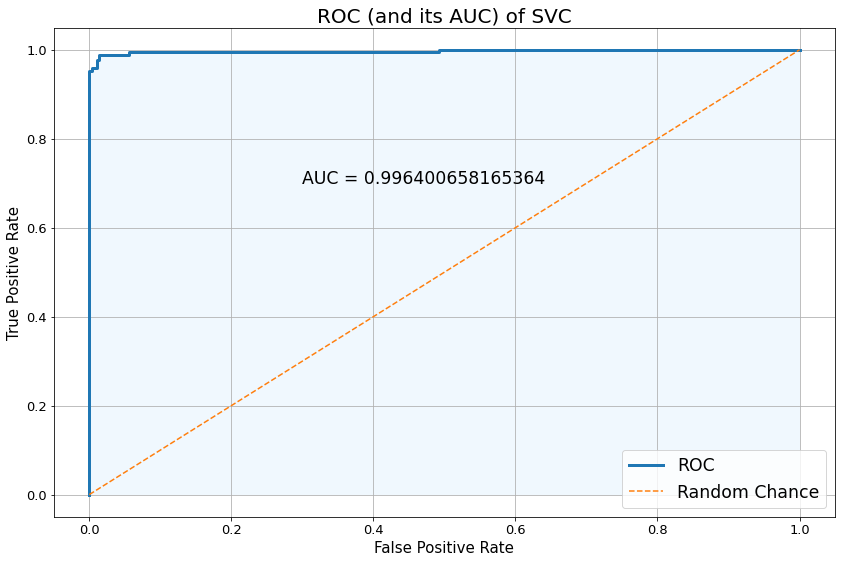


Sample Simulation of L1-Penalized SVC Results (on Test Set)


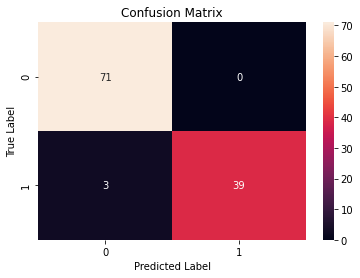

TN = 71 
FP = 0 
FN = 3 
TP = 39


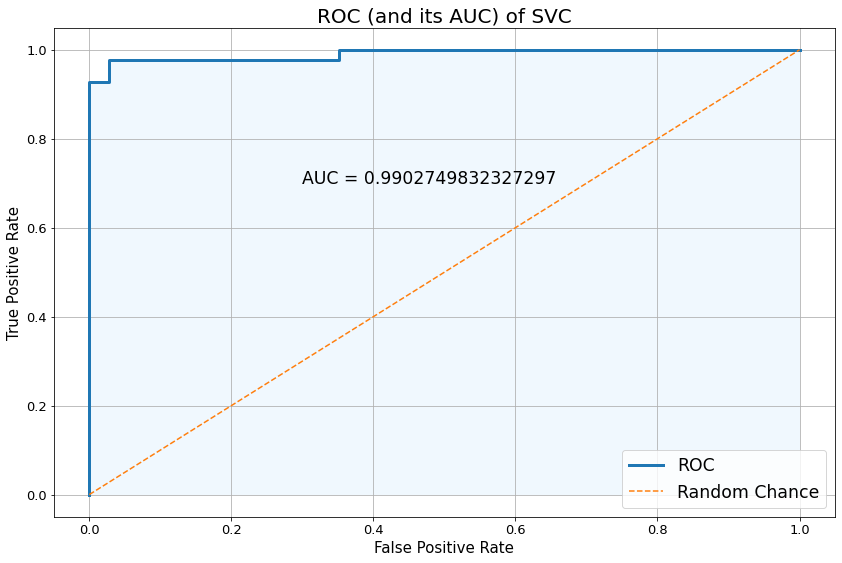


SVC Performance Results from 30 Monte Carlo Simulations


,Optimal C,Train: Accuracy,Train: Precision,Train: Recall,Train: F1-Score,Train: AUC,Test: Accuracy,Test: Precision,Test: Recall,Test: F1-Score,Test: AUC
Sim1,1.0,0.984649,0.988024,0.970588,0.979228,0.996874,0.982301,0.976190,0.976190,0.976190,0.999329
Sim2,1.0,0.978070,0.981928,0.958824,0.970238,0.996401,0.973451,1.000000,0.928571,0.962963,0.990275
Sim3,1.0,0.984649,0.982249,0.976471,0.979351,0.997306,0.964602,0.975000,0.928571,0.951220,0.995976
Sim4,1.0,0.984649,0.982249,0.976471,0.979351,0.997306,0.964602,0.975000,0.928571,0.951220,0.994970
Sim5,1.0,0.986842,0.988095,0.976471,0.982249,0.997306,0.973451,0.933333,1.000000,0.965517,1.000000
Sim6,10.0,0.995614,1.000000,0.988235,0.994083,0.999691,0.973451,0.975610,0.952381,0.963855,0.988263
Sim7,1.0,0.982456,0.987952,0.964706,0.976190,0.997038,0.991150,1.000000,0.976190,0.987952,0.999329
Sim8,1.0,0.986842,0.993976,0.970588,0.982143,0.996647,0.955752,1.000000,0.880952,0.936709,0.995641
Sim9,1.0,0.978070,0.976190,0.964706,0.970414,0.996503,0.982301,0.976190,0.976190,0.976190,0.999329
Sim10,1.0,0.978070,0.976190,0.964706,0.970414,0.996174,0.955752,1.000000,0.880952,0.936709,0.992287



Classifier's Monte Carlo performance values (i.e. the average of the 30 simulations)
____________________________________________________________________________________
Train: Accuracy_avg: 0.9854
Train: Precision_avg: 0.99
Train: Recall_avg: 0.9706
Train: F1-Score_avg: 0.9802
Train: AUC_avg: 0.9975
Test: Accuracy_avg: 0.9696
Test: Precision_avg: 0.9755
Test: Recall_avg: 0.9429
Test: F1-Score_avg: 0.9583
Test: AUC_avg: 0.9923


In [9]:
print("Classification with Supervised Learning\n")
Sup_MonteCarlo("Supervised: SVC")


-----------------
## 1.b.ii.A and B -  Semi-supervised Learning
(b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly se- lected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

ii. Semi-Supervised Learning/ Self-training: select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.

A. Train an L1-penalized SVM to classify the labeled data Use normalized data. Choose the penalty parameter using 5 fold cross validation.

B. Find the unlabeled data point that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

>As discussed with TA, it makes more sense to answer A and B together (especially due to Monte Carlo) <br>
The sections for A and B are roughly mentioned in the comments below.

In [10]:

# Monte Carlo requires an element of randomness; since when dual=False SVC isn't random, we need to randomly split the train/test set for each simulation
def SemiSup_MonteCarlo(alg):
    
    # I am going to output all of the relevant findings from the Monte Carlo simulations loops as a dataframe
    summary_df = pd.DataFrame(columns = ["Optimal C", "Train: Accuracy", "Train: Precision", "Train: Recall", "Train: F1-Score", "Train: AUC", "Test: Accuracy", "Test: Precision", "Test: Recall", "Test: F1-Score", "Test: AUC"])
    
    simulations = 30
    
    for M in range(simulations): 

        # I randomized the instances here; this is the varying element of randomness for the Monte Carlo
        wdbc_total = wdbc_total_orig.sample(frac=1, random_state=M+11).reset_index(drop=True)


        # These give the indices of our wdbc_total dataframe that satisfy the condition -- e.g. Diagnosis = 0 
        indices_0 = np.where(wdbc_total["Diagnosis"] == 0)[0]
        indices_1 = np.where(wdbc_total["Diagnosis"] == 1)[0]

        # we have seperate dataframes for wdbc when Diagnosis is 0 or 1
        wdbc_0 = pd.DataFrame(wdbc_total.iloc[indices_0], columns=wdbc_total.columns)
        wdbc_1 = pd.DataFrame(wdbc_total.iloc[indices_1], columns=wdbc_total.columns)

        # now we can take 20% of each to create the test set; and the training set with the remainder
        wdbc_test0 = wdbc_0.iloc[:round(wdbc_0.shape[0]*0.2)]
        wdbc_test1 = wdbc_1.iloc[:round(wdbc_1.shape[0]*0.2)]
        wdbc_train0 = wdbc_0.iloc[round(wdbc_0.shape[0]*0.2):]
        wdbc_train1 = wdbc_1.iloc[round(wdbc_1.shape[0]*0.2):]

        # We use the axis=0 parameter to indicate that it is the rows of the DFs that are being joined together.
        wdbc_test = pd.concat([wdbc_test0, wdbc_test1], ignore_index=True, axis=0).sample(frac=1, random_state=M+11).reset_index(drop=True)
        wdbc_train = pd.concat([wdbc_train0, wdbc_train1], ignore_index=True, axis=0).sample(frac=1, random_state=M+11).reset_index(drop=True)


        # The ID Number parameter isn't relevant for our tasks; so we ignore it here
        testX = wdbc_test.iloc[:, 2:]
        testY = wdbc_test.iloc[:, 1]
        trainX = wdbc_train.iloc[:, 2:]
        trainY = wdbc_train.iloc[:, 1]
        
        # we are told to normalize the data
        # First we need to train the normalizer on the train set and use that to transform both the training set and test so -- to avoid data leakage

        normalizer = MinMaxScaler()
        trainX_norm = pd.DataFrame(normalizer.fit_transform(trainX), columns=trainX.columns)
        testX_norm = pd.DataFrame(normalizer.transform(testX), columns=testX.columns)
        # Technically, the proper way to normalize with CV is by applying it within the CV folds (like with a pipeline) -- so there's no data leak
        # However, in Piazza @647 the professor said, "Standardization is not a form of learning so it’s not a big deal to standardize outside the CV loop."
        # The same is true for normalization; so, I did it this way for the sake of simplicity

        
        # select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data.
        # We randomized the complete dataset at the beginning of this loop; so, just splitting "trainX_norm" in half will qualify as random selection
        trainX_norm_lbld = trainX_norm.copy().iloc[:round(trainX_norm.shape[0]*.5)]
        trainX_norm_unlbld = trainX_norm.copy().iloc[round(trainX_norm.shape[0]*.5):].reset_index(drop=True)
        trainY_lbld = trainY.copy().iloc[:round(trainY.shape[0]*.5)]
#         trainY_unlbld = trainY.iloc[round(trainY.shape[0]*.5):].reset_index(drop=True)
        # Without ".copy()", the following error appears: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
        
    
        # start of A
        # hyper-parameter tuning (on the train set) for the penalty/regularization parameter C; we use the labeled training set

        C_set = [10**x for x in range(-3, 7, 1)]

        cv_scoreL = []
        for C in C_set:
            svc_model = LinearSVC(penalty="l1", C=C, dual=False, max_iter=500000)

            # using a 5-fold cross validation
            cv_score = cross_val_score(svc_model, trainX_norm_lbld, trainY_lbld, cv=5, scoring="accuracy").mean()
            # Since the estimator is a classifier and y is multiclass, StratifiedKFold is used for the cv parameter.
#             print("When C =", str(C) + ":\n\tCV (accuracy) Score =", cv_score)
            cv_scoreL.append((C, cv_score))

        # We use the parameter combo with the highest CV accuracy to train our SVC model
        cv_scoreL.sort(reverse=True, key=lambda x:x[1])
        best_C = cv_scoreL[0][0]
#         print("Best C:", best_C)    
    
        
        # Train an L1-penalized SVM to classify the labeled data
        svc_model = LinearSVC(penalty="l1", C=best_C, dual=False, max_iter=500000)
        svc_model.fit(trainX_norm_lbld, trainY_lbld)
        # end of A
        
        # start of B
        # We repeat these steps until there are 0 rows left in trainX_norm_unlbld
        while trainX_norm_unlbld.shape[0]:

            # Find the unlabeled data point that is the farthest to the decision boundary of the SVM. 
            # decision function "Predicts confidence scores for samples; The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane."
            conf_scores = list(svc_model.decision_function(trainX_norm_unlbld))
            # adding an index to the unlabeled instance scores
            distanceL = [(i, x) for i, x in enumerate(conf_scores)]

            # We want to pick the sample with the largest distance from the hyperplane
            distanceL.sort(reverse=True, key=lambda x:abs(x[1]))

            # distanceL[0][0] gives the index of the unlabeled training instance furthest from the hyperplane 
            # So, we need to label it, add it to the labeled training set, and retrain the SVC
            new_lbld_row = trainX_norm_unlbld.iloc[distanceL[0][0]]

            # adding a new row to an existing dataframe (with the ".loc" method)
            trainX_norm_lbld.loc[trainX_norm_lbld.shape[0]] =new_lbld_row
            # if the sign of the instace with the largest distance (from the hyperplane) is positive, we assign it the 1 label
            if distanceL[0][1] >= 0:
                trainY_lbld.loc[trainY_lbld.shape[0]] = 1
            else:
                trainY_lbld.loc[trainY_lbld.shape[0]] = 0

            # Now we need to drop the instance we just labeled from the trainX_norm_unlbld dataframe
            trainX_norm_unlbld = trainX_norm_unlbld.drop(labels=distanceL[0][0], axis=0).reset_index(drop=True)
            
            # retrain the model with the added labeled instance
            svc_model.fit(trainX_norm_lbld, trainY_lbld)
            # Continue this process until all unlabeled data are used. -- ie until loop terminates
        
        # Once the loop terminates, the entire training set will be labeled
        # In other words the SVC model we have will be one that was fitting on all training data (originally labeled and unlabeled)
        # Now, like in 1.b.i we simply test the model and measure it's performance 
        
        
        # Plot the ROC and report the confusion matrix for training and testing in one of the runs.
        
        # 1 is arbitary; could choose any of the 0-29 simulations
        if M == 1:
            accuracy_train, precision_train, recall_train, f1_train, auc_train = classification_summary(best_C, trainX_norm_lbld, trainY_lbld, trainX_norm_lbld, trainY_lbld, "Train Set", True)
            accuracy_test, precision_test, recall_test, f1_test, auc_test = classification_summary(best_C, trainX_norm_lbld, trainY_lbld, testX_norm, testY, "Test Set", True)
        else:
            accuracy_train, precision_train, recall_train, f1_train, auc_train = classification_summary(best_C, trainX_norm, trainY, trainX_norm, trainY, "Train Set")
            accuracy_test, precision_test, recall_test, f1_test, auc_test = classification_summary(best_C, trainX_norm, trainY, testX_norm, testY, "Test Set")

        row = [best_C, accuracy_train, precision_train, recall_train, f1_train, auc_train, accuracy_test, precision_test, recall_test, f1_test, auc_test]
        
        num = M+1
        summary_df.loc["Sim%d" %num] = row
    
    
    print("\nSVC Performance Results from 30 Monte Carlo Simulations")
    pd.set_option('display.max_rows', None)
    display(summary_df)
    pd.set_option("display.max_rows", 10)
    
    print("\nClassifier's Monte Carlo performance values (i.e. the average of the 30 simulations)"+\
          "\n____________________________________________________________________________________")
    
    
    # this is a dictionary that contains the Monte Carlo results
    monte_carloD = {}
    # in this loop, we take the average of all of our performance metrics and assign them to our dictionary
    for col in summary_df.columns[1:]:
        name = col+"_avg"
        avg = round( summary_df[col].mean(), 4)
        monte_carloD[name] = avg
        print(name + ":", avg)
    
    overall_summaryD[alg] = monte_carloD
    

Classification with Semi-Supervised Learning


Sample Simulation of L1-Penalized SVC Results (on Train Set)


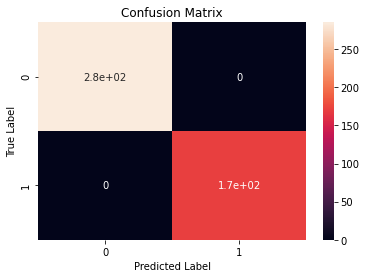

TN = 285 
FP = 0 
FN = 0 
TP = 171


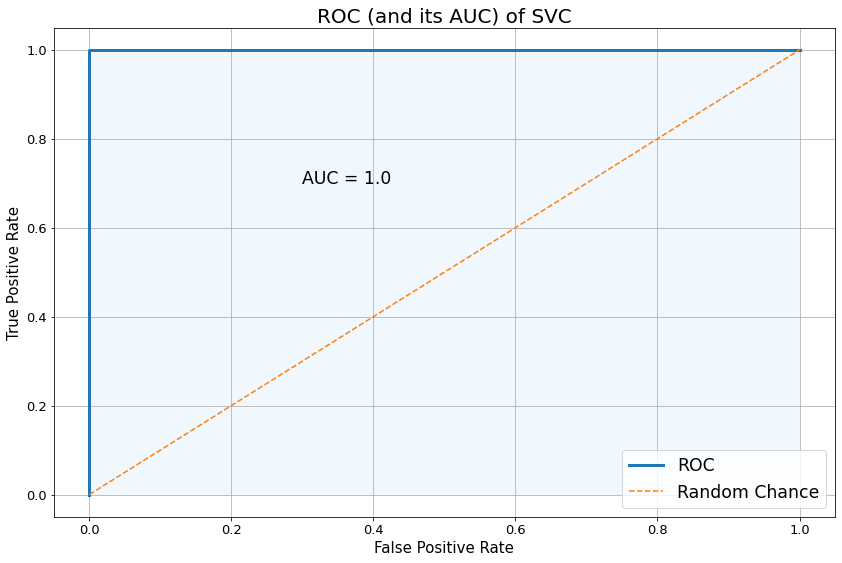


Sample Simulation of L1-Penalized SVC Results (on Test Set)


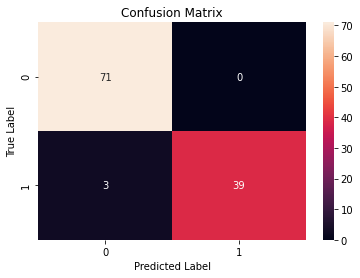

TN = 71 
FP = 0 
FN = 3 
TP = 39


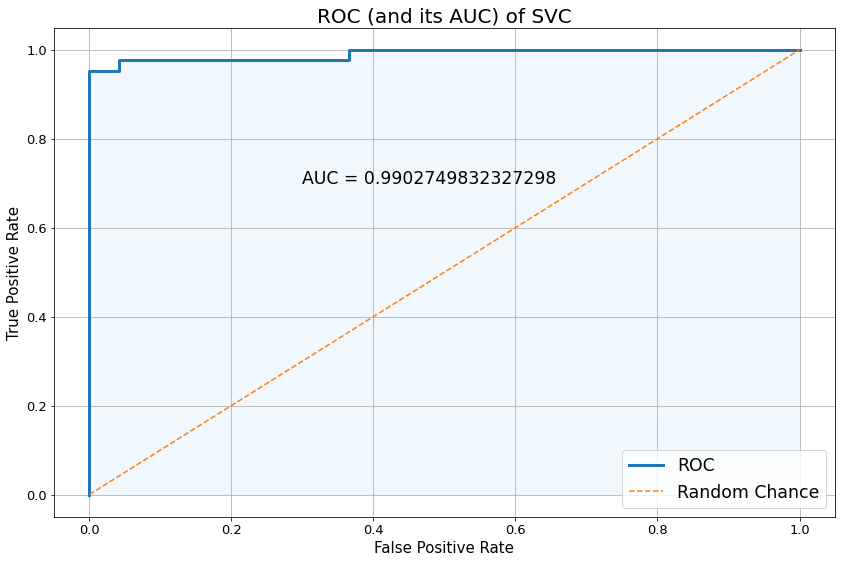


SVC Performance Results from 30 Monte Carlo Simulations


,Optimal C,Train: Accuracy,Train: Precision,Train: Recall,Train: F1-Score,Train: AUC,Test: Accuracy,Test: Precision,Test: Recall,Test: F1-Score,Test: AUC
Sim1,10.0,0.986842,0.988095,0.976471,0.982249,0.997902,0.982301,0.976190,0.976190,0.976190,0.998994
Sim2,10.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.973451,1.000000,0.928571,0.962963,0.990275
Sim3,10.0,0.991228,0.994048,0.982353,0.988166,0.998519,0.982301,0.976190,0.976190,0.976190,0.997988
Sim4,1.0,0.986842,0.988095,0.976471,0.982249,0.996072,0.982301,1.000000,0.952381,0.975610,0.993628
Sim5,10000.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.911504,0.921053,0.833333,0.875000,0.964118
Sim6,10.0,0.989035,0.994012,0.976471,0.985163,0.999013,0.964602,0.975000,0.928571,0.951220,0.986922
Sim7,1.0,0.991228,0.994048,0.982353,0.988166,0.998930,0.955752,0.951220,0.928571,0.939759,0.987592
Sim8,1.0,0.978070,0.981928,0.958824,0.970238,0.995804,0.982301,1.000000,0.952381,0.975610,0.990610
Sim9,1.0,0.986842,0.993976,0.970588,0.982143,0.996524,0.946903,0.973684,0.880952,0.925000,0.990946
Sim10,10.0,0.984649,0.988024,0.970588,0.979228,0.998519,0.982301,0.976190,0.976190,0.976190,0.998994



Classifier's Monte Carlo performance values (i.e. the average of the 30 simulations)
____________________________________________________________________________________
Train: Accuracy_avg: 0.9866
Train: Precision_avg: 0.9904
Train: Recall_avg: 0.9735
Train: F1-Score_avg: 0.9819
Train: AUC_avg: 0.9979
Test: Accuracy_avg: 0.9693
Test: Precision_avg: 0.9758
Test: Recall_avg: 0.9413
Test: F1-Score_avg: 0.9578
Test: AUC_avg: 0.9907


In [11]:
print("Classification with Semi-Supervised Learning\n")
SemiSup_MonteCarlo("Semi-Supervised: SVC")


-----------------
## 1.b.iii (A, B, and C) -  Unsupervised Learning
(b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly se- lected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

iii. Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.

A. Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?

B. Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.

C. Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

>As discussed with TA, it makes more sense to answer all of b.iii together (especially due to Monte Carlo)
The sections roughly mentioned in the comments below.

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

# This function will be used for other subquestions down the line as well

def unsup_classification_summary(testY, prediction, prediction_probs, set_type, pos_label, plot=False):
    
    matrix = confusion_matrix(testY, prediction)
    # print(matrix)
    
    matrix_flat = matrix.flatten()
    tn = matrix_flat[0]
    fp = matrix_flat[1]
    fn = matrix_flat[2]
    tp = matrix_flat[3]
    
    if plot:
        print("\nSample Simulation of L1-Penalized SVC Results (on", set_type + ")")
        
        # https://seaborn.pydata.org/generated/seaborn.heatmap.html
        sns.heatmap(matrix, annot=True)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)

    
    # performance metrics
    accuracy = (tp+tn)/(tp+fn+tn+fp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)


    # AUC/ROC

    # pos_label is the label of the positive class; our focus is the positive class (1)
    fpr, tpr, thresh = roc_curve(testY, prediction_probs[:, 1], pos_label=pos_label)

    # area under the ROC curve
    auc_val = auc(fpr, tpr)
    # print(auc_val)
    
    if plot:
        # setting plot size
        fig, ax = plt.subplots(figsize=(14, 9))
        # plots the predicitve power (i.e. prob curve) of our classifier
        ax.plot(fpr, tpr, label="ROC", linewidth=3)
        # plots the predictive power we would expect with random guessing
        ax.plot([0, 1], [0, 1], "--", label="Random Chance")
        ax.legend(loc="lower right", fontsize="xx-large")
        kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
        # The blue shaded region represnts the AOC -- ie it covers 100% of the area under ROC; 
        ax.fill_between(fpr, tpr, **kwargs)

        plt.grid(True)
        plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
        plt.tick_params(labelsize=13)
        plt.xlabel("False Positive Rate", fontsize=15)
        plt.ylabel("True Positive Rate", fontsize=15)
        plt.title("ROC (and its AUC) of SVC", fontsize=20)

        plt.show()

    return accuracy, precision, recall, f1, auc_val


### 1.b.iii.A
A. Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?

We are told to "Run the k-means algorithm multiple times" and are asked "How do you make sure that the algorithm was not trapped in a local minimum?" 
> The first requirement actually answers the second question. We can make sure we aren't trapped in a local minimum by running the k-means algorithm multiple times. The "n_init" parameter sets the number of times k-means algorithm will run internally with different centroid seeds. "The final results will be the best output of n_init consecutive runs." Sklearn's documentation for it further says that, "Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia." Therefore, by setting a (high) n_init (i.e. 30 which I used), we effectively run the k-means algorithm multiple times and make sure it's not trapped in a local minimum. You can change the n_init to 100 if you want to be very carefully, but I believe that for this it is unnecessarily expensive in terms of time and compuation.  <br>
Also, using the random_state parameter, we ensure our Monte Carlo simulations are all (pseudo)randomly initialized -- they're all different and reproducible (just like the dataset splits).
        

In [13]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html

def UnSup_MonteCarlo(alg):
    
    # I am going to output all of the relevant findings from the Monte Carlo simulations loops as a dataframe
    summary_df = pd.DataFrame(columns = ["Train Accuracy", "Train Precision", "Train Recall", "Train F1-Score", "Train AUC", "Test Accuracy", "Test Precision", "Test Recall", "Test F1-Score", "Test AUC"])
    
    simulations = 30
    
    for M in range(simulations): 
        
        # I randomized the instances here; this is the varying element of randomness for the Monte Carlo
        wdbc_total = wdbc_total_orig.sample(frac=1, random_state=M).reset_index(drop=True)


        # These give the indices of our wdbc_total dataframe that satisfy the condition -- e.g. Diagnosis = 0 
        indices_0 = np.where(wdbc_total["Diagnosis"] == 0)[0]
        indices_1 = np.where(wdbc_total["Diagnosis"] == 1)[0]

        # we have seperate dataframes for wdbc when Diagnosis is 0 or 1
        wdbc_0 = pd.DataFrame(wdbc_total.iloc[indices_0], columns=wdbc_total.columns)
        wdbc_1 = pd.DataFrame(wdbc_total.iloc[indices_1], columns=wdbc_total.columns)

        # now we can take 20% of each to create the test set; and the training set with the remainder
        wdbc_test0 = wdbc_0.iloc[:round(wdbc_0.shape[0]*0.2)]
        wdbc_test1 = wdbc_1.iloc[:round(wdbc_1.shape[0]*0.2)]
        wdbc_train0 = wdbc_0.iloc[round(wdbc_0.shape[0]*0.2):]
        wdbc_train1 = wdbc_1.iloc[round(wdbc_1.shape[0]*0.2):]

        # We use the axis=0 parameter to indicate that it is the rows of the DFs that are being joined together.
        wdbc_test = pd.concat([wdbc_test0, wdbc_test1], ignore_index=True, axis=0).sample(frac=1, random_state=M).reset_index(drop=True)
        wdbc_train = pd.concat([wdbc_train0, wdbc_train1], ignore_index=True, axis=0).sample(frac=1, random_state=M).reset_index(drop=True)
        

        # The ID Number parameter isn't relevant for our tasks; so we ignore it here
        testX = wdbc_test.iloc[:, 2:]
        testY = wdbc_test.iloc[:, 1]
        trainX = wdbc_train.iloc[:, 2:]
        trainY = wdbc_train.iloc[:, 1]
        
        # we are told to normalize the data
        # First we need to train the normalizer on the train set and use that to transform both the training set and test so -- to avoid data leakage
        normalizer = MinMaxScaler()
        trainX_norm = pd.DataFrame(normalizer.fit_transform(trainX), columns=trainX.columns)
        testX_norm = pd.DataFrame(normalizer.transform(testX), columns=testX.columns)
        
        
        # Now we create our k-means clustering model per A
        # Subquestion A specifies to run the k-means algorithm multiple times and initialize the algorithm randomly
        # These demands are met with the parameters we set
        # The n_init parameter sets the number of times k-means algorithm will run internally with different centroid seeds. 
        # "The final results will be the best output of n_init consecutive runs"; this is how we make sure the algorithm was not trapped in a local minimum (as question A asked)
        # With the random state, we ensure our Monte Carlo simulations are all (pseudo)randomly initialized -- they're all different and reproducible (just like the dataset splits)
        kmeans = KMeans(n_clusters=2, n_init = 30, random_state=M)
        # b.iii.A is answered with the kmeans initialization and the comments directly above; the markdown above
        
        
        # start of B
        # We need to classify/predict the training set instances based on the majority vote of the 30 points closest to each of the 2 centroid
        # Then, like before, we compare with the true labels and calculate the performance metrics
        cluster_labels = kmeans.fit_predict(trainX_norm)
        # fit_predict: "Compute cluster centers and predict cluster index for each sample"
        # By the way, the kmeans attribute "cluster_centers_" could give use the "Coordinates of cluster centers."; didn't need to use it though
        
        # We need to "find the closest 30 data points to each center."; the transform() method does exactly that: "each dimension is the distance to the cluster centers"
        # Each instance has an array with 3 distances; one to each cluster
        distances = kmeans.transform(trainX_norm)
        # We want to enumerate it such that the distances are associated with the correct instance's index
        distancesL = [(i, list(dist)) for i, dist in enumerate(distances)]
        
        # Now we find the 30 points closest to centroid 1 and centroid 2
        distancesL.sort(reverse=False, key=lambda x:x[1][0])
        # False sort least to greatest
        
        # The instance indices for Cluster 1's 30 closest data points
        cl1_top30_idx = [i for i, dist in distancesL.copy()[:30]]
        
        # Now we do the same but for cluster 2
        distancesL.sort(reverse=False, key=lambda x:x[1][1])
        cl2_top30_idx = [i for i, dist in distancesL.copy()[:30]]
        
        # Read the true labels of those 30 data points and take a majority poll within them.
        # ".iloc" can take a list or array of integers; so here we get a series of the true labels of the 30 closest datapoints to cluster 1
        # taking their mode will act as a majority poll
        cl1_class = int(trainY.iloc[cl1_top30_idx].mode())
        cl2_class = int(trainY.iloc[cl2_top30_idx].mode())
        
        pos_label = cl1_class
        
        # So, we use the cluster_labels variable to assign all instances their proper class label
        # By the way, technically the cluster name for cl1 is actually "0" and cl2 is "1"
        class_predsL_train = []
        for cluster_lbl in cluster_labels:
            # To reiterate, cluster label is just each clusters "name" assigned by the kmeans algorithm; cluster class, is the class prediction based on the majority polling we did
            if cluster_lbl == 0:
                class_predsL_train.append(cl1_class)
            elif cluster_lbl == 1:
                # could use "else" here but this was just more informative
                class_predsL_train.append(cl2_class)
        
        # For the ROC/AUC we also need the prediction probabilities
        # K-means algorithm does not provide probabilities, so one can use the distances from cluster center and pass them through a softmax to calculate probabilities.
        # We used the first method mentioned in footnote 2
        prediction_probs_train = softmax(distances, axis=1)
        # axis parameter is the axis to compute the softmax values along
        
        
        # start of C
        # Classify test data based on their proximity to the centers of the clusters. 
        # Using the same kmeans model we just trained on the training set, we predict the closest cluster each sample in our test set belongs to.
        cluster_labels = kmeans.predict(testX_norm)
        # Based on which cluster a data point is in, we assign it its class (based on the majority polling from the training set)
        class_predsL_test = []
        for cluster_lbl in cluster_labels:
            # To reiterate, cluster label is just each clusters "name" assigned by the kmeans algorithm; cluster class, is the class prediction based on the majority polling we did
            if cluster_lbl == 0:
                class_predsL_test.append(cl1_class)
            elif cluster_lbl == 1:
                # could use "else" here but this was just more informative
                class_predsL_test.append(cl2_class)
        
        # just like before, we also want the distances since it is needed for getting probabilities with softmax
        distances = kmeans.transform(testX_norm)
        prediction_probs_test = softmax(distances, axis=1)
        
        
        # Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.
        # This is for the last part of B and C
        
        # 0 is arbitary; could choose any of the 0-29 simulations
        if M == 0:
            accuracy_train, precision_train, recall_train, f1_train, auc_train = unsup_classification_summary(trainY, class_predsL_train, prediction_probs_train, "Train Set", pos_label, True)
            accuracy_test, precision_test, recall_test, f1_test, auc_test = unsup_classification_summary(testY, class_predsL_test, prediction_probs_test, "Test Set", pos_label, True)
        else:
            accuracy_train, precision_train, recall_train, f1_train, auc_train = unsup_classification_summary(trainY, class_predsL_train, prediction_probs_train, "Train Set", pos_label)
            accuracy_test, precision_test, recall_test, f1_test, auc_test = unsup_classification_summary(testY, class_predsL_test, prediction_probs_test, "Test Set", pos_label)

        row = [accuracy_train, precision_train, recall_train, f1_train, auc_train, accuracy_test, precision_test, recall_test, f1_test, auc_test]

        num = M+1
        summary_df.loc["Sim%d" %num] = row


    print("\nSVC Performance Results from 30 Monte Carlo Simulations")
    pd.set_option('display.max_rows', None)
    display(summary_df)
    pd.set_option("display.max_rows", 10)

    print("\nClassifier's Monte Carlo performance values (i.e. the average of the 30 simulations)"+\
          "\n____________________________________________________________________________________")


    # this is a dictionary that contains the Monte Carlo results
    monte_carloD = {}
    # in this loop, we take the average of all of our performance metrics and assign them to our dictionary
    for col in summary_df.columns:
        name = col+"_avg"
        avg = round( summary_df[col].mean(), 4)
        monte_carloD[name] = avg
        print(name + ":", avg)

    overall_summaryD[alg] = monte_carloD
        

Classification with Unsupervised Learning: K-Means Clustering


Sample Simulation of L1-Penalized SVC Results (on Train Set)


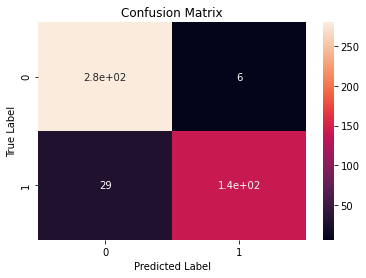

TN = 280 
FP = 6 
FN = 29 
TP = 141


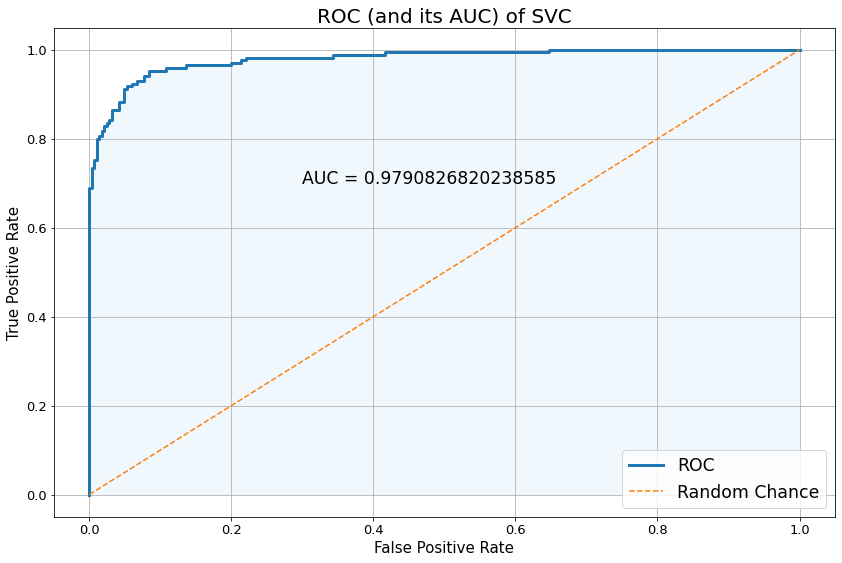


Sample Simulation of L1-Penalized SVC Results (on Test Set)


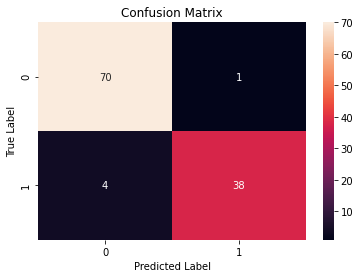

TN = 70 
FP = 1 
FN = 4 
TP = 38


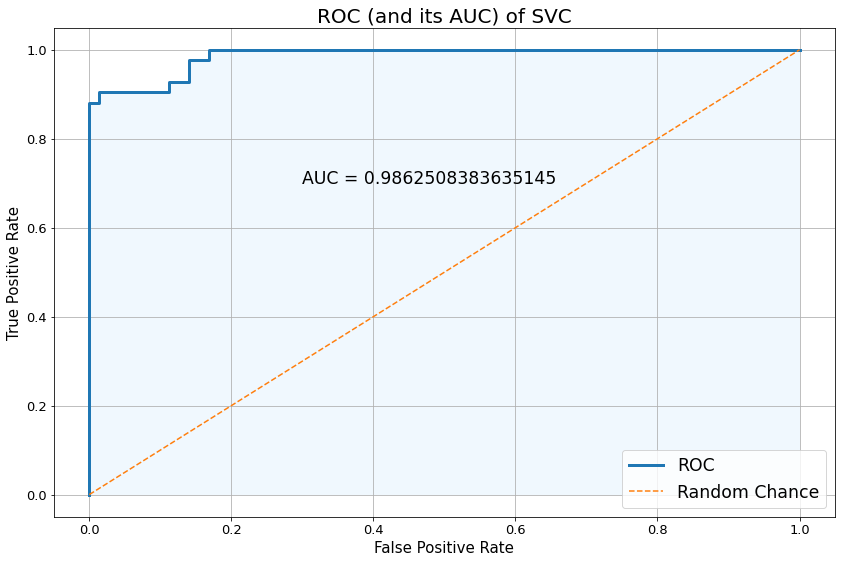


SVC Performance Results from 30 Monte Carlo Simulations


,Train Accuracy,Train Precision,Train Recall,Train F1-Score,Train AUC,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test AUC
Sim1,0.923246,0.959184,0.829412,0.889590,0.979083,0.955752,0.974359,0.904762,0.938272,0.986251
Sim2,0.932018,0.942675,0.870588,0.905199,0.983649,0.884956,0.914286,0.761905,0.831169,0.965124
Sim3,0.916667,0.940000,0.829412,0.881250,0.978095,0.955752,0.951220,0.928571,0.939759,0.977532
Sim4,0.934211,0.986111,0.835294,0.904459,0.981160,0.911504,0.944444,0.809524,0.871795,0.985245
Sim5,0.925439,0.978873,0.817647,0.891026,0.979844,0.955752,0.930233,0.952381,0.941176,0.993293
Sim6,0.927632,0.972414,0.829412,0.895238,0.984389,0.955752,0.951220,0.928571,0.939759,0.976190
Sim7,0.925439,0.972222,0.823529,0.891720,0.983937,0.929204,0.972222,0.833333,0.897436,0.990946
Sim8,0.938596,0.961039,0.870588,0.913580,0.982991,0.920354,1.000000,0.785714,0.880000,0.981221
Sim9,0.921053,0.935065,0.847059,0.888889,0.976717,0.929204,0.947368,0.857143,0.900000,0.989940
Sim10,0.923246,0.953020,0.835294,0.890282,0.979350,0.938053,0.948718,0.880952,0.913580,0.982897



Classifier's Monte Carlo performance values (i.e. the average of the 30 simulations)
____________________________________________________________________________________
Train Accuracy_avg: 0.9249
Train Precision_avg: 0.9494
Train Recall_avg: 0.8441
Train F1-Score_avg: 0.8934
Train AUC_avg: 0.9802
Test Accuracy_avg: 0.9307
Test Precision_avg: 0.9556
Test Recall_avg: 0.8548
Test F1-Score_avg: 0.9009
Test AUC_avg: 0.9812


In [14]:
print("Classification with Unsupervised Learning: K-Means Clustering\n")
UnSup_MonteCarlo("Unsupervised: K-Means")


-----------------
## 1.b.iv -  Spectral Clustering
(b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly se- lected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

iv. Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method.


"Spectral clustering is a technique with roots in graph theory, where the approach is used to identify communities of nodes in a graph based on the edges connecting them." "It treats each data point as a graph-node and thus transforms the clustering problem into a graph-partitioning problem." "In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex, or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster, such as when clusters are nested circles on the 2D plane."

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

def Spectral_MonteCarlo(alg):
    
    # I am going to output all of the relevant findings from the Monte Carlo simulations loops as a dataframe
    summary_df = pd.DataFrame(columns = ["Train Accuracy", "Train Precision", "Train Recall", "Train F1-Score", "Train AUC", "Test Accuracy", "Test Precision", "Test Recall", "Test F1-Score", "Test AUC"])
    
    simulations = 30
            
    for M in range(simulations): 

    #         M += 70

        # I randomized the instances here; this is the varying element of randomness for the Monte Carlo
        wdbc_total = wdbc_total_orig.sample(frac=1, random_state=M).reset_index(drop=True)


        # These give the indices of our wdbc_total dataframe that satisfy the condition -- e.g. Diagnosis = 0 
        indices_0 = np.where(wdbc_total["Diagnosis"] == 0)[0]
        indices_1 = np.where(wdbc_total["Diagnosis"] == 1)[0]

        # we have seperate dataframes for wdbc when Diagnosis is 0 or 1
        wdbc_0 = pd.DataFrame(wdbc_total.iloc[indices_0], columns=wdbc_total.columns)
        wdbc_1 = pd.DataFrame(wdbc_total.iloc[indices_1], columns=wdbc_total.columns)

        # display(wdbc_0)
        # display(wdbc_1)

        # now we can take 20% of each to create the test set; and the training set with the remainder
        wdbc_test0 = wdbc_0.iloc[:round(wdbc_0.shape[0]*0.2)]
        wdbc_test1 = wdbc_1.iloc[:round(wdbc_1.shape[0]*0.2)]
        wdbc_train0 = wdbc_0.iloc[round(wdbc_0.shape[0]*0.2):]
        wdbc_train1 = wdbc_1.iloc[round(wdbc_1.shape[0]*0.2):]

        # display(wdbc_test0)
        # display(wdbc_test1)
        # display(wdbc_train0)
        # display(wdbc_train1)

        # We use the axis=0 parameter to indicate that it is the rows of the DFs that are being joined together.
        wdbc_test = pd.concat([wdbc_test0, wdbc_test1], ignore_index=True, axis=0).sample(frac=1, random_state=M+100).reset_index(drop=True)
        wdbc_train = pd.concat([wdbc_train0, wdbc_train1], ignore_index=True, axis=0).sample(frac=1, random_state=M+100).reset_index(drop=True)


        # The ID Number parameter isn't relevant for our tasks; so we ignore it here
        testX = wdbc_test.iloc[:, 2:]
        testY = wdbc_test.iloc[:, 1]
        trainX = wdbc_train.iloc[:, 2:]
        trainY = wdbc_train.iloc[:, 1]

        # we are told to normalize the data
        # First we need to train the normalizer on the train set and use that to transform both the training set and test so -- to avoid data leakage

        normalizer = MinMaxScaler()
        trainX_norm = pd.DataFrame(normalizer.fit_transform(trainX), columns=trainX.columns)
        testX_norm = pd.DataFrame(normalizer.transform(testX), columns=testX.columns)


        # Now we create our spectral clustering model 
        spectral = SpectralClustering(n_clusters=2, gamma=1, affinity="rbf", n_init = 30, random_state=M)
        # Used RBF kernel and gamma=1, per prompt's suggestion


        # We need to classify/predict the training set instances based on the majority vote of the 30 points closest to each of the 2 centroid
        # Then, like before, we compare with the true labels and calculate the performance metrics
        cluster_labels = spectral.fit_predict(trainX_norm)
        # fit_predict: "Compute cluster centers and predict cluster index for each sample"

        # "Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters. Instead, use fit_predict method."
        # Since we don't use distance to pick the 30 closest data points for each cluster, we use all instances in each cluster for the majority polling

        # Technically the cluster name for cl1 is actually "0" and cl2 is "1"
        cl1_idx = np.where(cluster_labels == 0)[0]
        cl2_idx = np.where(cluster_labels == 1)[0]
        # These are the indices for the data points in each Cluster

        # taking their mode will act as a majority poll
        cl1_class = int(trainY.iloc[cl1_idx].mode())
        cl2_class = int(trainY.iloc[cl2_idx].mode())

        pos_label = cl1_class

        # So, we use the cluster_labels variable to assign all instances their proper class label
        class_predsL_train = []
        for cluster_lbl in cluster_labels:
            # To reiterate, cluster label is just each clusters "name" assigned by the spectral algorithm; cluster class, is the class prediction based on the majority polling we did
            if cluster_lbl == 0:
                class_predsL_train.append(cl1_class)
            elif cluster_lbl == 1:
                # could use "else" here but this was just more informative
                class_predsL_train.append(cl2_class)

        # For the ROC/AUC we also need the prediction probabilities
        # Spectral clustering algorithm does not provide probabilities nor distances on it's own
        # As discussed with the TA, to get the probabilities (for roc_curve) we will calculate distances for each instance using scipy's "cdist"
        # We measure the average distance of an instance to all instances in cluster 1, and then cluster 2. We do this for all instances
        # Since, we approximately know how far each clustered data point is from each cluster, this can be inputted into softmax to get a (sort of) probability for each classification
        # We essentially use the first method mentioned in footnote 2

        # This gives us all the instances contained in each cluster
        cl1_instances = trainX_norm.iloc[cl1_idx]
        cl2_instances = trainX_norm.iloc[cl2_idx]


        # We are creating a cluster-distance space using distance of an instance to each cluster (based on the average of the distance to all the cluster members)
        distancesL = []
        for i in range(trainX_norm.shape[0]):
            dist = []
            # this finds the average distance from the first instance in our training set to all members of cluster 1; in other words its the distance from instance i to cluster 1
            dist_to_cl1 = cdist(np.array(trainX_norm.iloc[i:i+1]), np.array(cl1_instances)).mean()
            dist.append(dist_to_cl1)
            # this finds the average distance from the first instance in our training set to all members of cluster 2; in other words its the distance from instance i to cluster 2
            dist_to_cl2 = cdist(np.array(trainX_norm.iloc[i:i+1]), np.array(cl2_instances)).mean()
            dist.append(dist_to_cl2)
            distancesL.append(dist)

        # We used the first method mentioned in footnote 2; we use softmax to get the "classification"/clustering probabilities from distances
        probabilities_train = softmax(np.array(distancesL), axis=1)
        # axis parameter is the axis to compute the softmax values along


        # Now we need to assign the test data to the appropriate cluster
        # However, since spectral clustering doesn't have a predict() method
        # So, per the TA's suggestion, we use a k=1 KNN fitted on the training set with cluster_labels as its Y; With k=1, the KNN training will match the clustering  
        # So then, we can use the KNN algorithm to predict what cluster test data would be assigned to -- i.e. the closest cluster each sample in our test set belongs to.
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(trainX_norm, cluster_labels)

        cluster_labels = knn.predict(testX_norm)
        # Based on which cluster a data point is in, we assign it its class (based on the majority polling from the training set)
        class_predsL_test = []
        for cluster_lbl in cluster_labels:
            # To reiterate, cluster label is just each clusters "name" assigned by the spectral clustering algorithm; cluster class, is the class prediction based on the majority polling we did
            if cluster_lbl == 0:
                class_predsL_test.append(cl1_class)
            elif cluster_lbl == 1:
                # could use "else" here but this was just more informative
                class_predsL_test.append(cl2_class)


        # just like before, we also want the probabilities; so we first calculate the distances use "cdist"
        # We are creating a cluster-distance space using distance of an instance to each cluster (based on the average of the distance to all the cluster members)
        distancesL = []
        for i in range(testX_norm.shape[0]):
            dist = []
            # this finds the average distance from the first instance in our test set to all members of cluster 1; in other words its the distance from instance i to cluster 1
            dist_to_cl1 = cdist(np.array(testX_norm.iloc[i:i+1]), np.array(cl1_instances)).mean()
            dist.append(dist_to_cl1)
            # this finds the average distance from the first instance in our test set to all members of cluster 2; in other words its the distance from instance i to cluster 2
            dist_to_cl2 = cdist(np.array(testX_norm.iloc[i:i+1]), np.array(cl2_instances)).mean()
            dist.append(dist_to_cl2)
            distancesL.append(dist)

        # We used the first method mentioned in footnote 2; we use softmax to get the "classification"/clustering probabilities from distances
        probabilities_test = softmax(np.array(distancesL), axis=1)


        # Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.        
        # 1 is arbitary; could choose any of the 0-29 simulations
        if M == 1:
            accuracy_train, precision_train, recall_train, f1_train, auc_train = unsup_classification_summary(trainY, class_predsL_train, probabilities_train, "Train Set", pos_label, True)
            accuracy_test, precision_test, recall_test, f1_test, auc_test = unsup_classification_summary(testY, class_predsL_test, probabilities_test, "Test Set", pos_label, True)
        else:
            accuracy_train, precision_train, recall_train, f1_train, auc_train = unsup_classification_summary(trainY, class_predsL_train, probabilities_train, "Train Set", pos_label)
            accuracy_test, precision_test, recall_test, f1_test, auc_test = unsup_classification_summary(testY, class_predsL_test, probabilities_test, "Test Set", pos_label)

        row = [accuracy_train, precision_train, recall_train, f1_train, auc_train, accuracy_test, precision_test, recall_test, f1_test, auc_test]

        num = M+1
        summary_df.loc["Sim%d" %num] = row


    print("\nSVC Performance Results from 30 Monte Carlo Simulations")
    pd.set_option('display.max_rows', None)
    display(summary_df)
    pd.set_option("display.max_rows", 10)

    print("\nClassifier's Monte Carlo performance values (i.e. the average of the 30 simulations)"+\
          "\n____________________________________________________________________________________")

    # this is a dictionary that contains the Monte Carlo results
    monte_carloD = {}
    # in this loop, we take the average of all of our performance metrics and assign them to our dictionary
    for col in summary_df.columns:
        name = col+"_avg"
        avg = round( summary_df[col].mean(), 4)
        monte_carloD[name] = avg
        print(name + ":", avg)

    overall_summaryD[alg] = monte_carloD
        

Classification with Unsupervised Learning: Spectral Clustering


Sample Simulation of L1-Penalized SVC Results (on Train Set)


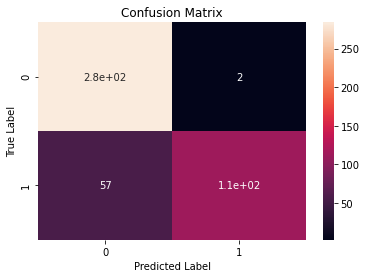

TN = 284 
FP = 2 
FN = 57 
TP = 113


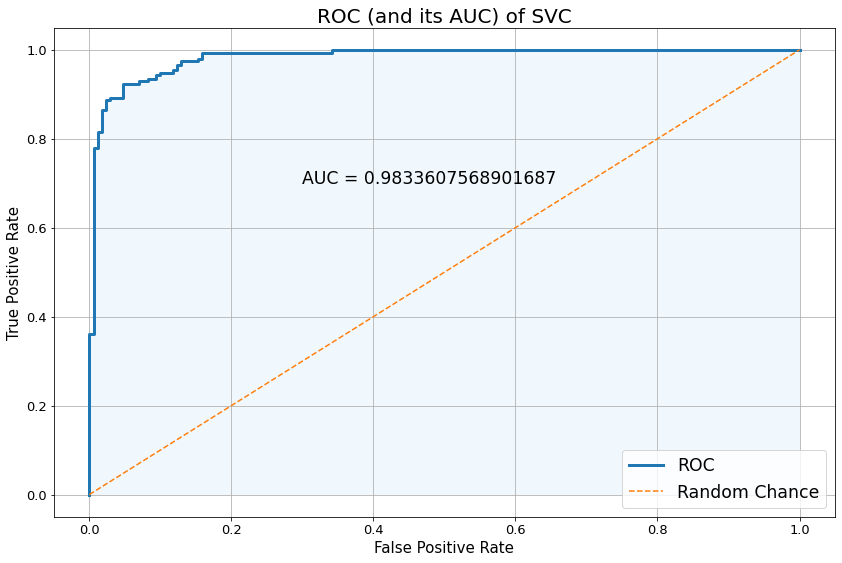


Sample Simulation of L1-Penalized SVC Results (on Test Set)


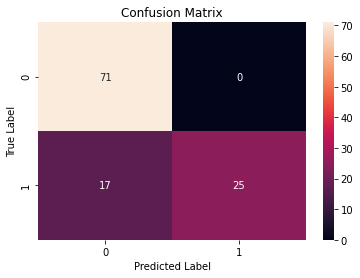

TN = 71 
FP = 0 
FN = 17 
TP = 25


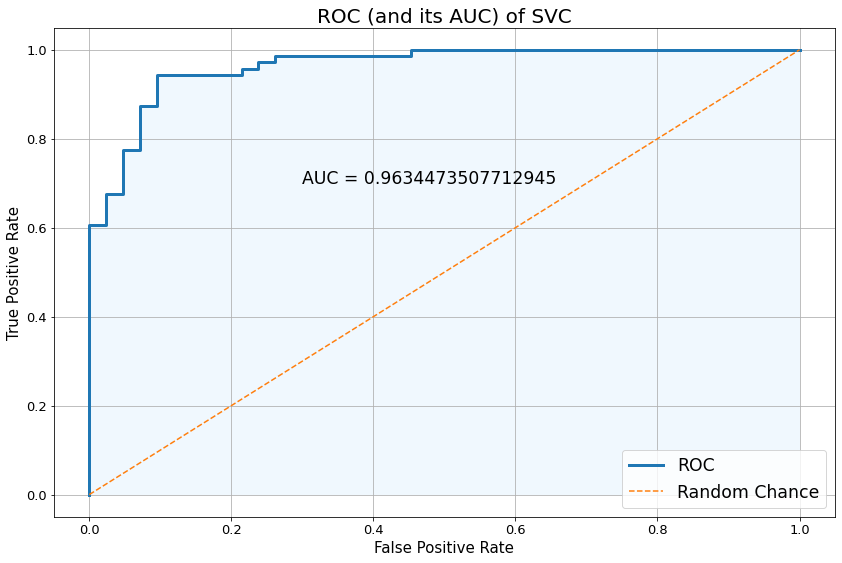


SVC Performance Results from 30 Monte Carlo Simulations


,Train Accuracy,Train Precision,Train Recall,Train F1-Score,Train AUC,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test AUC
Sim1,0.859649,0.973214,0.641176,0.773050,0.979720,0.902655,1.000000,0.738095,0.849315,0.986922
Sim2,0.870614,0.982609,0.664706,0.792982,0.983361,0.849558,1.000000,0.595238,0.746269,0.963447
Sim3,0.868421,0.991071,0.652941,0.787234,0.978754,0.849558,0.962963,0.619048,0.753623,0.976526
Sim4,0.846491,0.990196,0.594118,0.742647,0.981489,0.823009,1.000000,0.523810,0.687500,0.985580
Sim5,0.846491,0.990196,0.594118,0.742647,0.979268,0.876106,1.000000,0.666667,0.800000,0.989940
Sim6,0.868421,0.982456,0.658824,0.788732,0.984924,0.911504,1.000000,0.761905,0.864865,0.975184
Sim7,0.826754,1.000000,0.535294,0.697318,0.983998,0.814159,1.000000,0.500000,0.666667,0.993628
Sim8,0.859649,0.990741,0.629412,0.769784,0.982312,0.849558,1.000000,0.595238,0.746269,0.982897
Sim9,0.872807,0.974576,0.676471,0.798611,0.977088,0.867257,1.000000,0.642857,0.782609,0.991281
Sim10,0.820175,0.988889,0.523529,0.684615,0.977293,0.831858,1.000000,0.547619,0.707692,0.981891



Classifier's Monte Carlo performance values (i.e. the average of the 30 simulations)
____________________________________________________________________________________
Train Accuracy_avg: 0.8572
Train Precision_avg: 0.9826
Train Recall_avg: 0.6282
Train F1-Score_avg: 0.7653
Train AUC_avg: 0.9803
Test Accuracy_avg: 0.8596
Test Precision_avg: 0.9941
Test Recall_avg: 0.6262
Test F1-Score_avg: 0.765
Test AUC_avg: 0.9813


In [16]:
print("Classification with Unsupervised Learning: Spectral Clustering\n")
Spectral_MonteCarlo("Unsupervised: Spectral")

-----------------
## 1.b.v -  Summary
(b) Monte-Carlo Simulation: Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly se- lected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

v. One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.

In [17]:

print("Summary Results for the Average of 50 Monte Carlo Simulations")

summary = pd.DataFrame(columns = ["Train: Accuracy", "Train: Precision", "Train: Recall", "Train: F1-Score", "Train: AUC", "Test: Accuracy", "Test: Precision", "Test: Recall", "Test: F1-Score", "Test: AUC"])

for key, values in overall_summaryD.items():
    row = []
    for k, v in values.items():
        row.append(v)
    
    summary.loc[key] = row
    
display(summary)    

Summary Results for the Average of 50 Monte Carlo Simulations


,Train: Accuracy,Train: Precision,Train: Recall,Train: F1-Score,Train: AUC,Test: Accuracy,Test: Precision,Test: Recall,Test: F1-Score,Test: AUC
Supervised: SVC,0.9854,0.9900,0.9706,0.9802,0.9975,0.9696,0.9755,0.9429,0.9583,0.9923
Semi-Supervised: SVC,0.9866,0.9904,0.9735,0.9819,0.9979,0.9693,0.9758,0.9413,0.9578,0.9907
Unsupervised: K-Means,0.9249,0.9494,0.8441,0.8934,0.9802,0.9307,0.9556,0.8548,0.9009,0.9812
Unsupervised: Spectral,0.8572,0.9826,0.6282,0.7653,0.9803,0.8596,0.9941,0.6262,0.7650,0.9813


>The results, as seen in the summary table above, support our expectations that the supervised model performs consistently better on (nearly) all metrics compared to both unsupervised models. The classificatin results using spectral clustering understandably has the worst performance -- by quite a bit. The unsupervised K-Means method also performs consistently worse than its supervised counterpart -- but not by as much. The semi-supervised SVC performed very well; even better than expected. However, most relevant performance metrics -- like average test accuracy and test F1-score -- are still better; though by not as much. To reiterate, the results support our expectations; the more information we had (and used) when training a model, the better it performed overall.

---------------
# 2. Active Learning Using Support Vector Machines

## 2.a
(a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. 
Choose 472 data points ran- domly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.


The link above gives the following information about the dataset's features:
1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

In [18]:
banknote_data = "../data/data_banknote_authentication.csv"

attrL = ["variance", "skewness", "curtosis", "entropy", "class"]

bank_total_orig = pd.read_csv(banknote_data, header = None, names=attrL)

display(bank_total_orig)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


Since we repeat the procedures in (b) 50 times, we need an element of randomness -- like with Monte Carlo in Q1. So, as suggested by the TA I talked to, the train and test set randomized split should occur seperately (i.e. differently) for every procedure. So, there is no point to randomly create a train and test set.

In [19]:
# We could though, with the following code; this code will be used in the loop below (in 2.b)
# So, uncomment the lines below if you want to see a sample randomized split

# # First, we can just randomize all of the dataset, then simply pick the "first" 472 data points for the test set
# bank_total = bank_total_orig.sample(frac=1, random_state=0).reset_index(drop=True)
# test_set = bank_total.iloc[:472].reset_index(drop=True)
# train_set = bank_total.iloc[472:].reset_index(drop=True)

# display(train_set)
# display(test_set)


---------
## 2.b.i

(b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

i. Train a SVM with a pool of 10 randomly selected datapoints from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation. Repeat this process by adding 10 other randomly

In [20]:
# "You will have 50 errors for 90 SVMs per each procedure."; I will create a dataframe to output these results

columnsL = []
for i in range(10, 901, 10): 
    name = "Test Error (with Train N=" + str(i) +")"
    columnsL.append(name)

passive_df = pd.DataFrame(columns=columnsL)


In [21]:
# from sklearn.utils import check_random_state
# from tqdm import tqdm

# This will takes hours to run; you may want to change the number of simulations here (and for the next procedure) to a smaller number
# I had to do most of the testing with a smaller number (i.e. 10); that's why the output visible on github is for that many; the code is accurate for 50 as required though
# That is why the outputs you see on Github for Q2 will likely be for 10 iterations -- because that was how I last tested it
# However, the code itself if run, is for 50 iterations as required
simulations = 50

for M in range(simulations): 

    # First, we can just randomize all of the dataset, then simply pick the "first" 472 data points for the test set
    bank_total = bank_total_orig.sample(frac=1, random_state=M).reset_index(drop=True)
    test = bank_total.iloc[:472].reset_index(drop=True)
    train = bank_total.iloc[472:].reset_index(drop=True)

    trainX = train.iloc[:, :-1]
    trainY = train.iloc[:, -1]
    testX = test.iloc[:, :-1]
    testY = test.iloc[:, -1]

    # Although not explicitly asked for, the TA said it would be good to normalize our data; normalization is general a good idea for any algorithm using distances
    # First we need to train the normalizer on the train set and use that to transform both the training set and test so -- to avoid data leakage

    normalizer = MinMaxScaler()
    trainX_norm = pd.DataFrame(normalizer.fit_transform(trainX), columns=trainX.columns)
    testX_norm = pd.DataFrame(normalizer.transform(testX), columns=testX.columns)
    # Technically, the proper way to normalize with CV is by applying it within the CV folds (like with a pipeline) -- so there's no data leak
    # However, in Piazza @647 the professor said, "Standardization is not a form of learning so it’s not a big deal to standardize outside the CV loop."
    # The same is true for normalization; so, I did it this way for the sake of simplicity

    # in the loop below, we will find 90 test errors (per procedure); this list will collect them to later display
    errorsL = []

    # these are all possible indices 0-899 of the train set that we will randomly choose from
    train_idxL = list(range(0, trainX_norm.shape[0], 1))
    pool_idxL = []

    # Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty.
    # Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points.
    for i in tqdm(range(len(range(10, 901, 10))), "Sim"+str(M+1)):    
        # every iteration, we add 10 more random instances to our pool
        # I basically create a random state (which we will vary for iterations) that will be constant when rerunning the program
        random_seed = check_random_state(M+100)
        pool_idxL += list(random_seed.choice(train_idxL, 10, replace=False))
    #     pool_idxL += list(np.random.choice(train_idxL, 10, replace=False))

        # When picking the first 10 samples (and in general), we need to make sure our pool has at least one (preferably 2) of each class; on rare occasion could miss the minority class
        num = 1000
        while ( list(trainY.iloc[pool_idxL]).count(0) < 1 ) or ( list(trainY.iloc[pool_idxL]).count(1) < 1 ):
            pool_idxL = pool_idxL[:-10]
            random_seed = check_random_state(M+num)
            pool_idxL += list(random_seed.choice(train_idxL, 10, replace=False))
#             pool_idxL += list(np.random.choice(train_idxL, 10, replace=False))
            num += 1

            
        # Do NOT replace the samples back into the training set at each step.
        for idx in pool_idxL[10*i:]:
            train_idxL.remove(idx)
            # We take out the already chosen instances from consideration for future iterations

        poolX = trainX_norm.iloc[pool_idxL]
        poolY = trainY.iloc[pool_idxL]


        # hyper-parameter tuning (on the train set) for the penalty/regularization parameter C; we use the labeled training set. 
        # As suggested in footnote 4, manually tested and found very small and very large parameters for a range -- with a lower limit of ~70%
        C_set = [10**x for x in range(-3, 7, 1)]

        cv_scoreL = []
        for C in C_set:
            svc_model = LinearSVC(penalty="l1", C=C, dual=False, max_iter=500000)

            # using a 5-fold cross validation; TA on Piazza said not to use stratified to prevent: "UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5."
            cv_score = cross_val_score(svc_model, poolX, poolY, cv=KFold(n_splits=5, shuffle=True, random_state=i), scoring="accuracy").mean()
    #         print("When C =", str(C) + ":\n\tCV (accuracy) Score =", cv_score)
            cv_scoreL.append((C, cv_score))

        # We use the parameter combo with the highest CV accuracy to train our SVC model
        cv_scoreL.sort(reverse=True, key=lambda x:x[1])
        best_C = cv_scoreL[0][0]
    #     print("Best C:", best_C)    


        # Train an L1-penalized SVM to classify the labeled data
        svc_model = LinearSVC(penalty="l1", C=best_C, dual=False, max_iter=500000)
        svc_model.fit(poolX, poolY)

        # "Calculate the test error for each SVM."; test error is the misclassification rate i.e. 1 - accuracy 

        # our classifier's label predictions
        prediction = svc_model.predict(testX_norm)

        matrix = confusion_matrix(testY, prediction)
        matrix_flat = matrix.flatten()
        tn = matrix_flat[0]
        fp = matrix_flat[1]
        fn = matrix_flat[2]
        tp = matrix_flat[3]

        error = (fp+fn)/(tp+fn+tn+fp)
        errorsL.append(error)

    num = M+1
    # adding a new row to an existing dataframe (with the ".loc" method)
    passive_df.loc["Sim%d" %num] = errorsL

# Keep in mind, this takes rather long to load

    

Sim10: 100%|██████████| 90/90 [02:23<00:00,  1.60s/it]


In [22]:
print("Passive Learning Performance with L1-Penalized SVC")
display(passive_df)


Passive Learning Performance with L1-Penalized SVC


,Test Error (with Train N=10),Test Error (with Train N=20),Test Error (with Train N=30),Test Error (with Train N=40),Test Error (with Train N=50),Test Error (with Train N=60),Test Error (with Train N=70),Test Error (with Train N=80),Test Error (with Train N=90),Test Error (with Train N=100),Test Error (with Train N=110),Test Error (with Train N=120),Test Error (with Train N=130),Test Error (with Train N=140),Test Error (with Train N=150),Test Error (with Train N=160),Test Error (with Train N=170),Test Error (with Train N=180),Test Error (with Train N=190),Test Error (with Train N=200),Test Error (with Train N=210),Test Error (with Train N=220),Test Error (with Train N=230),Test Error (with Train N=240),Test Error (with Train N=250),Test Error (with Train N=260),Test Error (with Train N=270),Test Error (with Train N=280),Test Error (with Train N=290),Test Error (with Train N=300),Test Error (with Train N=310),Test Error (with Train N=320),Test Error (with Train N=330),Test Error (with Train N=340),Test Error (with Train N=350),Test Error (with Train N=360),Test Error (with Train N=370),Test Error (with Train N=380),Test Error (with Train N=390),Test Error (with Train N=400),Test Error (with Train N=410),Test Error (with Train N=420),Test Error (with Train N=430),Test Error (with Train N=440),Test Error (with Train N=450),Test Error (with Train N=460),Test Error (with Train N=470),Test Error (with Train N=480),Test Error (with Train N=490),Test Error (with Train N=500),Test Error (with Train N=510),Test Error (with Train N=520),Test Error (with Train N=530),Test Error (with Train N=540),Test Error (with Train N=550),Test Error (with Train N=560),Test Error (with Train N=570),Test Error (with Train N=580),Test Error (with Train N=590),Test Error (with Train N=600),Test Error (with Train N=610),Test Error (with Train N=620),Test Error (with Train N=630),Test Error (with Train N=640),Test Error (with Train N=650),Test Error (with Train N=660),Test Error (with Train N=670),Test Error (with Train N=680),Test Error (with Train N=690),Test Error (with Train N=700),Test Error (with Train N=710),Test Error (with Train N=720),Test Error (with Train N=730),Test Error (with Train N=740),Test Error (with Train N=750),Test Error (with Train N=760),Test Error (with Train N=770),Test Error (with Train N=780),Test Error (with Train N=790),Test Error (with Train N=800),Test Error (with Train N=810),Test Error (with Train N=820),Test Error (with Train N=830),Test Error (with Train N=840),Test Error (with Train N=850),Test Error (with Train N=860),Test Error (with Train N=870),Test Error (with Train N=880),Test Error (with Train N=890),Test Error (with Train N=900)
Sim1,0.055085,0.021186,0.033898,0.023305,0.033898,0.036017,0.031780,0.031780,0.031780,0.036017,0.033898,0.023305,0.023305,0.033898,0.016949,0.016949,0.016949,0.031780,0.023305,0.021186,0.023305,0.023305,0.025424,0.019068,0.019068,0.019068,0.019068,0.021186,0.021186,0.021186,0.019068,0.019068,0.019068,0.019068,0.019068,0.019068,0.019068,0.019068,0.019068,0.019068,0.019068,0.012712,0.016949,0.016949,0.012712,0.019068,0.016949,0.019068,0.014831,0.019068,0.019068,0.019068,0.012712,0.019068,0.019068,0.019068,0.012712,0.019068,0.012712,0.012712,0.012712,0.012712,0.012712,0.014831,0.014831,0.014831,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.012712,0.019068,0.012712,0.012712,0.012712,0.012712
Sim2,0.184322,0.029661,0.021186,0.021186,0.025424,0.025424,0.010593,0.010593,0.019068,0.023305,0.023305,0.023305,0.021186,0.023305,0.016949,0.021186,0.010593,0.010593,0.019068,0.014831,0.014831,0.014831,0.014831,0.016949,0.019068,0.012712,0.016949,0.012712,0.016949,0.016949,0.021186,0.016949,0.016949,0.016949,0.016949,0.016949,0.016949,0.021186,0.021186,0.023305,0.016949,0.014831,0.014831,0.014831,0.014831,0.010593,0.010593,0.010593,0.016949,0.010593,0.010593,0.010593,0.010593,0.010593,0.

---------
## 2.b.ii

(b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

ii. Traina SVM with a pool of 10 randomly selected datapoints from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

In [23]:
# "You will have 50 errors for 90 SVMs per each procedure."; I will create a dataframe to output these results

columnsL = []
for i in range(10, 901, 10): 
    name = "Test Error (with Train N=" + str(i) +")"
    columnsL.append(name)

active_df = pd.DataFrame(columns=columnsL)

In [24]:
# from sklearn.utils import check_random_state
# from tqdm import tqdm

simulations = 50

for M in range(simulations): 

    # First, we can just randomize all of the dataset, then simply pick the "first" 472 data points for the test set
    bank_total = bank_total_orig.sample(frac=1, random_state=M+10).reset_index(drop=True)
    test = bank_total.iloc[:472].reset_index(drop=True)
    train = bank_total.iloc[472:].reset_index(drop=True)

    trainX = train.iloc[:, :-1]
    trainY = train.iloc[:, -1]
    testX = test.iloc[:, :-1]
    testY = test.iloc[:, -1]

    # Although not explicitly asked for, the TA said it would be good to normalize our data; normalization is general a good idea for any algorithm using distances
    # First we need to train the normalizer on the train set and use that to transform both the training set and test so -- to avoid data leakage

    normalizer = MinMaxScaler()
    trainX_norm = pd.DataFrame(normalizer.fit_transform(trainX), columns=trainX.columns)
    testX_norm = pd.DataFrame(normalizer.transform(testX), columns=testX.columns)
    # Technically, the proper way to normalize with CV is by applying it within the CV folds (like with a pipeline) -- so there's no data leak
    # However, in Piazza @647 the professor said, "Standardization is not a form of learning so it’s not a big deal to standardize outside the CV loop."
    # The same is true for normalization; so, I did it this way for the sake of simplicity

    # in the loop below, we will find 90 test errors (per procedure); this list will collect them to later display
    errorsL = []

    # these are all possible indices 0-899 of the train set that we will randomly choose from
    train_idxL = list(range(0, trainX_norm.shape[0], 1))
    pool_idxL = []

    # Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty.
    # Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points.
    for i in tqdm(range(len(range(10, 901, 10))), "Sim"+str(M+1)):    
        # every iteration, we add 10 more random instances to our pool
        # I basically create a random state (which we will vary for iterations) that will be constant when rerunning the program
        random_seed = check_random_state(M+100)
        if i == 0:
            pool_idxL += list(random_seed.choice(train_idxL, 10, replace=False))
    #     pool_idxL += list(np.random.choice(train_idxL, 10, replace=False))

            num = 1000
            # Need to make sure the first pool of 10 has at least one sample from each class -- or else minority might get excluded; 
            while ( list(trainY.iloc[pool_idxL]).count(0) < 1 ) or ( list(trainY.iloc[pool_idxL]).count(1) < 1 ):
                pool_idxL = pool_idxL[:-10]
                random_seed = check_random_state(M+num)
                pool_idxL += list(random_seed.choice(train_idxL, 10, replace=False))
    #             pool_idxL += list(np.random.choice(train_idxL, 10, replace=False))
                num += 1
        
            # Do NOT replace the samples back into the training set at each step.
            for idx in pool_idxL[10*i:]:
                train_idxL.remove(idx)
                # We take out the already chosen instances from consideration for future iterations

            poolX = trainX_norm.iloc[pool_idxL]
            poolY = trainY.iloc[pool_idxL]
        
        
        else:
            # Choose the 10 closest data points in the training set to the hyperplane of the SVM and add them to the pool.            
            trainX_remaining = trainX_norm.iloc[train_idxL]
            trainY_remaining = trainY.iloc[train_idxL]
            
#             svc_model = LinearSVC(penalty="l1", C=best_C, dual=False, max_iter=1000000)
#             svc_model.fit(trainX_remaining, trainY_remaining)
            
            # decision_function of linear SVC "Predicts confidence scores for samples; The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane."
            conf_scores = list(svc_model.decision_function(trainX_remaining))
            # So, we can find the 10 closest datapoints (in our remaining train set) to the hyperplane
            distanceL = [(i, x) for i, x in enumerate(conf_scores)]
            # !!!
            # We want to pick the sample with the smallest distance from the hyperplane
            distanceL.sort(reverse=False, key=lambda x:abs(x[1]))
#             print(train_idxL)
#             print(distanceL)

            # distT[0][0] from distanceL[:10] gives the indices of the 10 training instance closest to the hyperplane 
            train_idx_newL = [distT[0] for distT in distanceL[:10]]
            closest10_idx = []
            for idx in train_idx_newL:
                closest = train_idxL[idx]
                closest10_idx.append(closest)
            
#             print(train_idxL)
#             print(trainX_remaining)
#             print()

#             print()
            
            pool_idxL += closest10_idx
            
            
#             print(1, pool_idxL)
            # Do NOT replace the samples back into the training set at each step.
            for idx in pool_idxL[10*i:]:
                train_idxL.remove(idx)
#             print(2, train_idxL)
#             print()


                # We take out the already chosen instances from consideration for future iterations
            
            
            # Now, we need to train our SVC with the new pool and it's new best_C

            poolX = trainX_norm.iloc[pool_idxL]
            poolY = trainY.iloc[pool_idxL]
            

        # hyper-parameter tuning (on the train set) for the penalty/regularization parameter C; we use the labeled training set. 
        # As suggested in footnote 4, manually tested and found very small and very large parameters for a range -- with a lower limit of ~70%
        C_set = [10**x for x in range(-3, 7, 1)]

        cv_scoreL = []
        for C in C_set:
            svc_model = LinearSVC(penalty="l1", C=C, dual=False, max_iter=500000)

            # using a 5-fold cross validation; TA on Piazza said not to use stratified to prevent: "UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5."
            cv_score = cross_val_score(svc_model, poolX, poolY, cv=KFold(n_splits=5, shuffle=True, random_state=i), scoring="accuracy").mean()
    #         print("When C =", str(C) + ":\n\tCV (accuracy) Score =", cv_score)
            cv_scoreL.append((C, cv_score))

        # We use the parameter combo with the highest CV accuracy to train our SVC model
        cv_scoreL.sort(reverse=True, key=lambda x:x[1])
        best_C = cv_scoreL[0][0]
    #     print("Best C:", best_C)    


        # Train an L1-penalized SVM to classify the labeled data
        svc_model = LinearSVC(penalty="l1", C=best_C, dual=False, max_iter=500000)
        svc_model.fit(poolX, poolY)

        # "Calculate the test error for each SVM."; test error is the misclassification rate i.e. 1 - accuracy 

        # our classifier's label predictions
        prediction = svc_model.predict(testX_norm)

        matrix = confusion_matrix(testY, prediction)
        matrix_flat = matrix.flatten()
        tn = matrix_flat[0]
        fp = matrix_flat[1]
        fn = matrix_flat[2]
        tp = matrix_flat[3]

        error = (fp+fn)/(tp+fn+tn+fp)
        errorsL.append(error)

    num = M+1
    # adding a new row to an existing dataframe (with the ".loc" method)
    active_df.loc["Sim%d" %num] = errorsL

# Keep in mind, this takes a while to load

    

Sim10: 100%|██████████| 90/90 [03:18<00:00,  2.20s/it]


In [25]:
print("Active Learning Performance with L1-Penalized SVC")
display(active_df)


Active Learning Performance with L1-Penalized SVC


,Test Error (with Train N=10),Test Error (with Train N=20),Test Error (with Train N=30),Test Error (with Train N=40),Test Error (with Train N=50),Test Error (with Train N=60),Test Error (with Train N=70),Test Error (with Train N=80),Test Error (with Train N=90),Test Error (with Train N=100),Test Error (with Train N=110),Test Error (with Train N=120),Test Error (with Train N=130),Test Error (with Train N=140),Test Error (with Train N=150),Test Error (with Train N=160),Test Error (with Train N=170),Test Error (with Train N=180),Test Error (with Train N=190),Test Error (with Train N=200),Test Error (with Train N=210),Test Error (with Train N=220),Test Error (with Train N=230),Test Error (with Train N=240),Test Error (with Train N=250),Test Error (with Train N=260),Test Error (with Train N=270),Test Error (with Train N=280),Test Error (with Train N=290),Test Error (with Train N=300),Test Error (with Train N=310),Test Error (with Train N=320),Test Error (with Train N=330),Test Error (with Train N=340),Test Error (with Train N=350),Test Error (with Train N=360),Test Error (with Train N=370),Test Error (with Train N=380),Test Error (with Train N=390),Test Error (with Train N=400),Test Error (with Train N=410),Test Error (with Train N=420),Test Error (with Train N=430),Test Error (with Train N=440),Test Error (with Train N=450),Test Error (with Train N=460),Test Error (with Train N=470),Test Error (with Train N=480),Test Error (with Train N=490),Test Error (with Train N=500),Test Error (with Train N=510),Test Error (with Train N=520),Test Error (with Train N=530),Test Error (with Train N=540),Test Error (with Train N=550),Test Error (with Train N=560),Test Error (with Train N=570),Test Error (with Train N=580),Test Error (with Train N=590),Test Error (with Train N=600),Test Error (with Train N=610),Test Error (with Train N=620),Test Error (with Train N=630),Test Error (with Train N=640),Test Error (with Train N=650),Test Error (with Train N=660),Test Error (with Train N=670),Test Error (with Train N=680),Test Error (with Train N=690),Test Error (with Train N=700),Test Error (with Train N=710),Test Error (with Train N=720),Test Error (with Train N=730),Test Error (with Train N=740),Test Error (with Train N=750),Test Error (with Train N=760),Test Error (with Train N=770),Test Error (with Train N=780),Test Error (with Train N=790),Test Error (with Train N=800),Test Error (with Train N=810),Test Error (with Train N=820),Test Error (with Train N=830),Test Error (with Train N=840),Test Error (with Train N=850),Test Error (with Train N=860),Test Error (with Train N=870),Test Error (with Train N=880),Test Error (with Train N=890),Test Error (with Train N=900)
Sim1,0.360169,0.023305,0.014831,0.006356,0.004237,0.004237,0.004237,0.008475,0.006356,0.006356,0.008475,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.008475,0.006356,0.008475,0.006356,0.006356,0.006356,0.006356,0.008475,0.008475,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.008475,0.008475,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
Sim2,0.069915,0.040254,0.023305,0.021186,0.271186,0.021186,0.016949,0.019068,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.019068,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.019068,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.014831,0.

---------
## 2.c

(c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

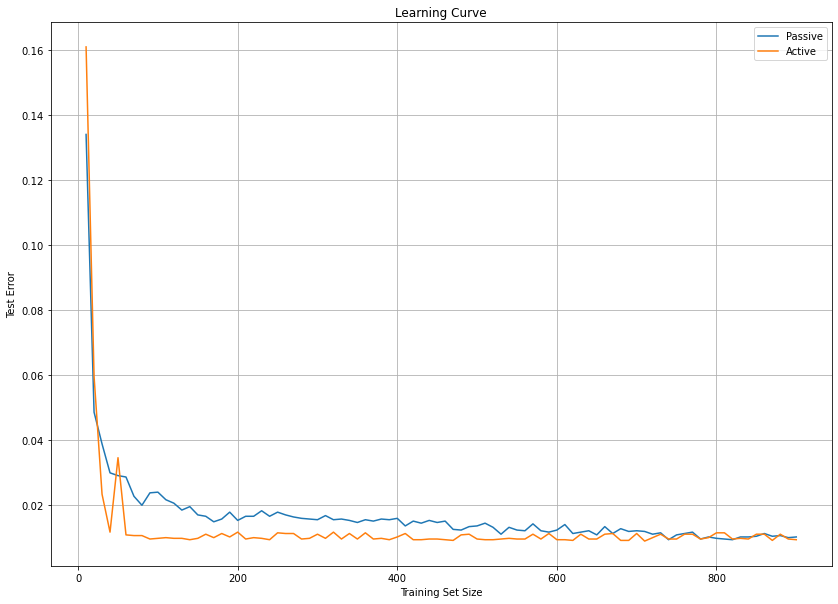

In [26]:
# Monte Carlo learning curve 

instancesL = range(10, 901, 10)

passive_avgL = []
for col in passive_df.columns:
    avg = passive_df[col].mean()
    passive_avgL.append(avg)

active_avgL = []
for col in active_df.columns:
    avg = active_df[col].mean()
    active_avgL.append(avg)

# Now we have the averages
# print(passive_avgL)
# print(active_avgL)

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(instancesL, passive_avgL, label='Passive')
ax.plot(instancesL, active_avgL, label='Active')
ax.set_xlabel("Training Set Size")
ax.set_ylabel("Test Error")
ax.legend()

plt.grid(True)
plt.title("Learning Curve")
plt.show()
